In [1]:
from data_formats import read_data
from dose_reponse_fit import dose_response_fit, StandardSettings
import matplotlib.pyplot as plt
from plotting import *
from stress_survival_conversion import stress_to_survival, survival_to_stress
import random
import glob
from tqdm import tqdm

In [55]:
path = "data/naeem_Esfenvalerate_2019.xlsx"

data  = read_data(path)

settings = StandardSettings(survival_max=data.meta.max_survival)

main_fit = dose_response_fit(data.main_series, settings)

stressor = random.choice(list(data.additional_stress.keys()))

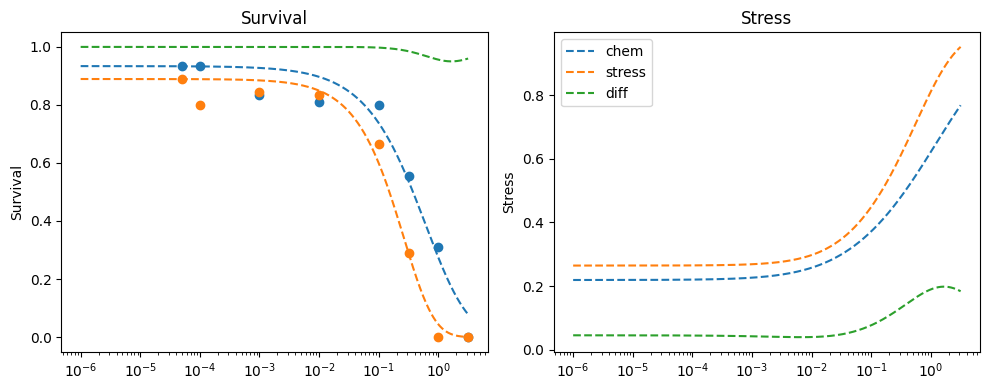

In [56]:
settings = StandardSettings(survival_max=data.meta.max_survival)

main_fit = dose_response_fit(data.main_series, settings)

stress_fit = dose_response_fit(data.additional_stress[stressor], settings)

fig, axs = plt.subplots(1,2, figsize=(10, 4))

xscale = "log"

def plot_1(model, label):
    return plot_survival(
        model.concentration_curve,
        model.survival_curve,
        ax=axs[0],
        orig_series=model.inputs,
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Survival",
        title="Survival",
        label = label,
        color=None
    )
    
def plot_2(model, label):
    plot_stress(
        model.concentration_curve,
        model.stress_curve,
        ax=axs[1],
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Stress",
        title="Stress",
        label=label,
        color = None
    )
  

plot_1(main_fit, "chem")
plot_1(stress_fit, "stress")

plot_2(main_fit, "chem")
plot_2(stress_fit, "stress")

diff = stress_fit.stress_curve - main_fit.stress_curve 

plot_stress(
        main_fit.concentration_curve,
        diff,
        ax=axs[1],
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Stress",
        title="Stress",
        label="diff",
        color = None
    )


surv_diff = stress_to_survival(diff) * data.meta.max_survival

if settings.param_d_norm:
    surv_diff *= main_fit.optim_param["d"]

plot_survival(
        main_fit.concentration_curve,
        surv_diff,
        ax=axs[0],
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Survival",
        title="Survival",
        label = "diff",
        color=None
    )

axs[-1].legend()
plt.tight_layout()
plt.show()

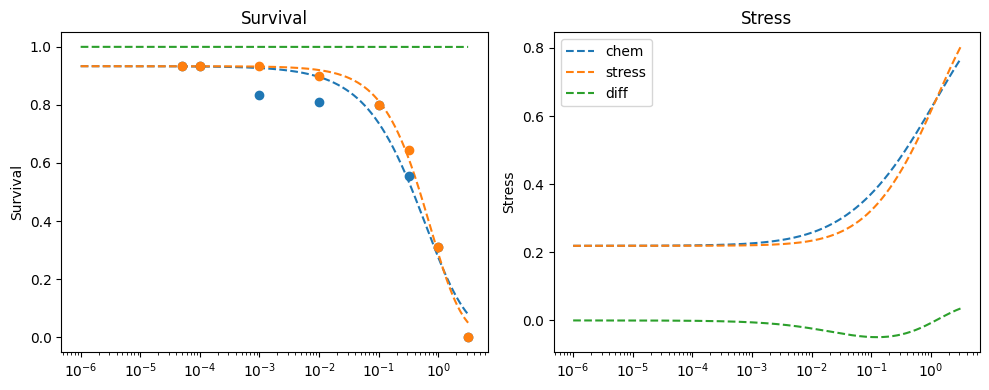

KeyboardInterrupt: 

In [59]:
path = "data/naeem_Esfenvalerate_2019.xlsx"

for paht in glob.glob("data/*.xlsx"):

    data  = read_data(path)

    for stressor in data.additional_stress.keys():
    
        
        settings = StandardSettings(survival_max=data.meta.max_survival)

        main_fit = dose_response_fit(data.main_series, settings)



        settings = StandardSettings(survival_max=data.meta.max_survival)

        main_fit = dose_response_fit(data.main_series, settings)

        stress_fit = dose_response_fit(data.additional_stress[stressor], settings)

        fig, axs = plt.subplots(1,2, figsize=(10, 4))

        xscale = "log"

        def plot_1(model, label):
            return plot_survival(
                model.concentration_curve,
                model.survival_curve,
                ax=axs[0],
                orig_series=model.inputs,
                xscale=xscale,
                show_legend=False,
                xlab=None,
                ylab="Survival",
                title="Survival",
                label = label,
                color=None
            )
            
        def plot_2(model, label):
            plot_stress(
                model.concentration_curve,
                model.stress_curve,
                ax=axs[1],
                xscale=xscale,
                show_legend=False,
                xlab=None,
                ylab="Stress",
                title="Stress",
                label=label,
                color = None
            )
        

        plot_1(main_fit, "chem")
        plot_1(stress_fit, "stress")

        plot_2(main_fit, "chem")
        plot_2(stress_fit, "stress")

        diff = stress_fit.stress_curve - main_fit.stress_curve 

        plot_stress(
                main_fit.concentration_curve,
                diff,
                ax=axs[1],
                xscale=xscale,
                show_legend=False,
                xlab=None,
                ylab="Stress",
                title="Stress",
                label="diff",
                color = None
            )


        surv_diff = stress_to_survival(diff) * data.meta.max_survival

        if settings.param_d_norm:
            surv_diff *= main_fit.optim_param["d"]

        plot_survival(
                main_fit.concentration_curve,
                surv_diff,
                ax=axs[0],
                xscale=xscale,
                show_legend=False,
                xlab=None,
                ylab="Survival",
                title="Survival",
                label = "diff",
                color=None
            )

        axs[-1].legend()
        plt.tight_layout()
        plt.show()

In [3]:
datas = [read_data(path)  for path in glob.glob("data/*.xlsx")]
datas = [(i,k) for i in datas for k in i.additional_stress.keys() ]

fits = []

for (data, stressor) in tqdm(datas):
    settings = StandardSettings(survival_max=data.meta.max_survival)

    main_fit = dose_response_fit(data.main_series, settings)

    settings = StandardSettings(survival_max=data.meta.max_survival)

    main_fit = dose_response_fit(data.main_series, settings)

    stress_fit = dose_response_fit(data.additional_stress[stressor], settings)
    
    fits.append((data, stressor, main_fit, stress_fit))

100%|██████████| 42/42 [00:30<00:00,  1.36it/s]


In [31]:
def get_curves(p, q):


    diffs = []

    for (data, stressor, main_fit, stress_fit) in tqdm(fits, disable=True):
        
        main_fit : ModelPredictions
        stress_fit : ModelPredictions

        main_stress = survival_to_stress(main_fit.survival_curve, p=p, q=q)
        stress_stress = survival_to_stress(stress_fit.survival_curve, p=p, q=q)

        diff = stress_stress - main_stress 
        diffs.append(diff)


    stds = np.std(diffs, axis=1)
    print(stds.shape)

    return stds.mean()

In [32]:
diffs = get_curves(3.2,3.2)
diffs

(42,)


0.063130754463543

In [34]:
import optuna

def experiment(trial):
    return get_curves(trial.suggest_float("p",1,13), trial.suggest_float("q",1,13))
 
study = optuna.create_study()
study.optimize(experiment, n_trials=100, n_jobs=7, show_progress_bar=True)

[I 2024-09-12 10:44:40,787] A new study created in memory with name: no-name-d959df3c-daed-46b6-ac1e-8171ab0264b5
Best trial: 0. Best value: 0.0461708:   2%|▏         | 2/100 [00:03<02:12,  1.35s/it]

(42,)
[I 2024-09-12 10:44:43,885] Trial 1 finished with value: 0.047782864469176414 and parameters: {'p': 2.184003196406986, 'q': 4.460835148956812}. Best is trial 1 with value: 0.047782864469176414.
(42,)
[I 2024-09-12 10:44:44,019] Trial 0 finished with value: 0.04617076546915958 and parameters: {'p': 1.811032681270671, 'q': 4.2488017805535385}. Best is trial 0 with value: 0.04617076546915958.


Best trial: 0. Best value: 0.0461708:   3%|▎         | 3/100 [00:04<02:09,  1.33s/it]

(42,)
(42,)
[I 2024-09-12 10:44:45,325] Trial 3 finished with value: 0.07949400821516416 and parameters: {'p': 6.077696355182704, 'q': 2.662494467870118}. Best is trial 0 with value: 0.04617076546915958.
[I 2024-09-12 10:44:45,329] Trial 6 finished with value: 0.05568858007716172 and parameters: {'p': 4.706823604144236, 'q': 5.711123363822405}. Best is trial 0 with value: 0.04617076546915958.


Best trial: 5. Best value: 0.0300893:   6%|▌         | 6/100 [00:04<00:46,  2.03it/s]

(42,)
[I 2024-09-12 10:44:45,559] Trial 2 finished with value: 0.04179533227398798 and parameters: {'p': 4.983893521463315, 'q': 10.2562858995096}. Best is trial 2 with value: 0.04179533227398798.
(42,)
(42,)
[I 2024-09-12 10:44:45,676] Trial 5 finished with value: 0.030089335260017447 and parameters: {'p': 3.0535401820543955, 'q': 11.946339886993659}. Best is trial 5 with value: 0.030089335260017447.
[I 2024-09-12 10:44:45,680] Trial 4 finished with value: 0.047340805965559306 and parameters: {'p': 4.674095505765331, 'q': 7.829868052189644}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:   8%|▊         | 8/100 [00:05<00:46,  1.96it/s]

(42,)
[I 2024-09-12 10:44:46,742] Trial 7 finished with value: 0.055960938268570404 and parameters: {'p': 2.1695780874856214, 'q': 3.208519313873743}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:   9%|▉         | 9/100 [00:07<00:58,  1.55it/s]

(42,)
[I 2024-09-12 10:44:47,815] Trial 8 finished with value: 0.056895416832786636 and parameters: {'p': 3.5275015030090646, 'q': 4.367445763680655}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  10%|█         | 10/100 [00:07<01:04,  1.39it/s]

(42,)
[I 2024-09-12 10:44:48,731] Trial 10 finished with value: 0.05846865212728477 and parameters: {'p': 11.82731841877291, 'q': 11.113637564778566}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  11%|█         | 11/100 [00:08<01:10,  1.26it/s]

(42,)
[I 2024-09-12 10:44:49,713] Trial 11 finished with value: 0.04743318596370325 and parameters: {'p': 7.445035665346481, 'q': 11.37656027818352}. Best is trial 5 with value: 0.030089335260017447.
(42,)
[I 2024-09-12 10:44:49,786] Trial 9 finished with value: 0.04832896562154354 and parameters: {'p': 6.6129840012441585, 'q': 9.959544468627367}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  13%|█▎        | 13/100 [00:09<00:53,  1.64it/s]

(42,)
(42,)
[I 2024-09-12 10:44:50,469] Trial 12 finished with value: 0.06469094006223589 and parameters: {'p': 7.881411288625303, 'q': 6.153494812079274}. Best is trial 5 with value: 0.030089335260017447.
[I 2024-09-12 10:44:50,472] Trial 13 finished with value: 0.045669314548110275 and parameters: {'p': 4.9622681024087925, 'q': 8.760559941769857}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  15%|█▌        | 15/100 [00:10<00:42,  2.01it/s]

(42,)
[I 2024-09-12 10:44:51,114] Trial 14 finished with value: 0.06681333028197646 and parameters: {'p': 8.628666765976726, 'q': 6.104216046693848}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  16%|█▌        | 16/100 [00:10<00:43,  1.92it/s]

(42,)
[I 2024-09-12 10:44:51,709] Trial 15 finished with value: 0.08561030558247837 and parameters: {'p': 8.821542114984608, 'q': 2.597095110307972}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  17%|█▋        | 17/100 [00:11<00:51,  1.61it/s]

(42,)
[I 2024-09-12 10:44:52,657] Trial 16 finished with value: 0.04634730325928693 and parameters: {'p': 8.285350056426843, 'q': 12.982628067220677}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  18%|█▊        | 18/100 [00:12<00:50,  1.63it/s]

(42,)
[I 2024-09-12 10:44:53,251] Trial 17 finished with value: 0.057067625961093826 and parameters: {'p': 8.612828642348267, 'q': 8.909438710921819}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 5. Best value: 0.0300893:  19%|█▉        | 19/100 [00:13<00:54,  1.49it/s]

(42,)
[I 2024-09-12 10:44:54,083] Trial 18 finished with value: 0.04851533256010504 and parameters: {'p': 8.965644109298914, 'q': 12.771976412740276}. Best is trial 5 with value: 0.030089335260017447.


Best trial: 21. Best value: 0.0181858:  20%|██        | 20/100 [00:13<00:46,  1.72it/s]

(42,)
[I 2024-09-12 10:44:54,432] Trial 21 finished with value: 0.01818575709163556 and parameters: {'p': 1.054683981360085, 'q': 12.995509723099467}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  22%|██▏       | 22/100 [00:14<00:31,  2.44it/s]

(42,)
[I 2024-09-12 10:44:54,715] Trial 19 finished with value: 0.04861804275037785 and parameters: {'p': 8.935629367033176, 'q': 12.685326016368535}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:44:54,898] Trial 20 finished with value: 0.04999252702685976 and parameters: {'p': 9.421370408336738, 'q': 12.594678389130959}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  23%|██▎       | 23/100 [00:15<00:47,  1.60it/s]

(42,)
[I 2024-09-12 10:44:56,045] Trial 22 finished with value: 0.03202811163288985 and parameters: {'p': 3.585014954829697, 'q': 12.188445611590486}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  24%|██▍       | 24/100 [00:16<00:55,  1.36it/s]

(42,)
[I 2024-09-12 10:44:57,053] Trial 23 finished with value: 0.029908444583875607 and parameters: {'p': 3.3958428231338464, 'q': 12.962606327755644}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  25%|██▌       | 25/100 [00:16<00:49,  1.51it/s]

(42,)
[I 2024-09-12 10:44:57,534] Trial 26 finished with value: 0.019680978788535093 and parameters: {'p': 1.0682565052240316, 'q': 11.847400229554227}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  26%|██▌       | 26/100 [00:17<00:43,  1.71it/s]

(42,)
[I 2024-09-12 10:44:57,942] Trial 24 finished with value: 0.03035718852683317 and parameters: {'p': 3.49450580384304, 'q': 12.944656724723158}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  27%|██▋       | 27/100 [00:17<00:48,  1.51it/s]

(42,)
[I 2024-09-12 10:44:58,779] Trial 25 finished with value: 0.033887289831749635 and parameters: {'p': 3.4149757395230997, 'q': 10.820717043870145}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  28%|██▊       | 28/100 [00:18<00:51,  1.41it/s]

(42,)
(42,)
[I 2024-09-12 10:44:59,590] Trial 28 finished with value: 0.03382163870886216 and parameters: {'p': 3.5117283309827254, 'q': 11.069355509261884}. Best is trial 21 with value: 0.01818575709163556.
[I 2024-09-12 10:44:59,607] Trial 29 finished with value: 0.02036910811430389 and parameters: {'p': 1.1046065248864938, 'q': 11.513719613278885}. Best is trial 21 with value: 0.01818575709163556.
(42,)


Best trial: 21. Best value: 0.0181858:  30%|███       | 30/100 [00:19<00:29,  2.34it/s]

[I 2024-09-12 10:44:59,796] Trial 27 finished with value: 0.03366695653787969 and parameters: {'p': 3.4656956230540334, 'q': 11.042823028553144}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  31%|███       | 31/100 [00:19<00:37,  1.85it/s]

(42,)
[I 2024-09-12 10:45:00,653] Trial 30 finished with value: 0.022205865593896482 and parameters: {'p': 1.3124528894886174, 'q': 11.155777707017734}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  32%|███▏      | 32/100 [00:20<00:31,  2.17it/s]

(42,)
[I 2024-09-12 10:45:00,913] Trial 31 finished with value: 0.02142396359184818 and parameters: {'p': 1.0472368425431653, 'q': 10.545965502771182}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  33%|███▎      | 33/100 [00:20<00:28,  2.37it/s]

(42,)
[I 2024-09-12 10:45:01,237] Trial 32 finished with value: 0.021798048226586774 and parameters: {'p': 1.0796063784158878, 'q': 10.450978868591916}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:01,294] Trial 33 finished with value: 0.07838147604465913 and parameters: {'p': 1.5443608061056493, 'q': 1.1207062233421397}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  35%|███▌      | 35/100 [00:21<00:29,  2.22it/s]

(42,)
[I 2024-09-12 10:45:02,217] Trial 35 finished with value: 0.07004773346293763 and parameters: {'p': 1.339078659289958, 'q': 1.393334605571157}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  37%|███▋      | 37/100 [00:22<00:29,  2.14it/s]

(42,)
[I 2024-09-12 10:45:03,187] Trial 34 finished with value: 0.02321248258032168 and parameters: {'p': 1.1412587237980865, 'q': 9.86691375094193}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:03,334] Trial 36 finished with value: 0.024162440004585742 and parameters: {'p': 1.1738199549004265, 'q': 9.47376572860807}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  38%|███▊      | 38/100 [00:23<00:32,  1.89it/s]

(42,)
[I 2024-09-12 10:45:04,010] Trial 37 finished with value: 0.02220120539454205 and parameters: {'p': 1.0089279574786503, 'q': 9.911764041336188}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  39%|███▉      | 39/100 [00:23<00:30,  2.01it/s]

(42,)
[I 2024-09-12 10:45:04,454] Trial 38 finished with value: 0.023349186892486558 and parameters: {'p': 1.09305272988125, 'q': 9.605038055492688}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  41%|████      | 41/100 [00:24<00:21,  2.76it/s]

(42,)
[I 2024-09-12 10:45:04,806] Trial 39 finished with value: 0.029728193870264426 and parameters: {'p': 1.7940968212173238, 'q': 8.767321602184106}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:04,936] Trial 40 finished with value: 0.027139582472689015 and parameters: {'p': 2.374247670848554, 'q': 11.755953365616978}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  42%|████▏     | 42/100 [00:25<00:34,  1.68it/s]

(42,)
[I 2024-09-12 10:45:06,092] Trial 41 finished with value: 0.032126691339658876 and parameters: {'p': 2.4859535659090293, 'q': 9.482003548124013}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  43%|████▎     | 43/100 [00:25<00:34,  1.64it/s]

(42,)
[I 2024-09-12 10:45:06,746] Trial 43 finished with value: 0.026588340679245013 and parameters: {'p': 2.269369119704, 'q': 11.767117295745436}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  44%|████▍     | 44/100 [00:26<00:28,  1.98it/s]

(42,)
[I 2024-09-12 10:45:07,000] Trial 42 finished with value: 0.03316218286711252 and parameters: {'p': 2.5569594629613217, 'q': 9.201910159106534}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  45%|████▌     | 45/100 [00:26<00:29,  1.90it/s]

(42,)
[I 2024-09-12 10:45:07,579] Trial 44 finished with value: 0.02826219577745241 and parameters: {'p': 2.5753708868120997, 'q': 11.685043924769092}. Best is trial 21 with value: 0.01818575709163556.


(42,)
[I 2024-09-12 10:45:08,390] Trial 45 finished with value: 0.03724390696043078 and parameters: {'p': 2.4944116876249964, 'q': 7.547081045652323}. Best is trial 21 with value: 0.01818575709163556.
(42,)


Best trial: 21. Best value: 0.0181858:  48%|████▊     | 48/100 [00:27<00:19,  2.65it/s]

[I 2024-09-12 10:45:08,585] Trial 47 finished with value: 0.02986059681687752 and parameters: {'p': 2.44180648722764, 'q': 10.443383696737502}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:08,704] Trial 46 finished with value: 0.03851151316964839 and parameters: {'p': 2.598796857391913, 'q': 7.337248091209373}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  49%|████▉     | 49/100 [00:28<00:22,  2.23it/s]

(42,)
[I 2024-09-12 10:45:09,324] Trial 48 finished with value: 0.026844796870694933 and parameters: {'p': 2.3485451740699492, 'q': 11.856415847028}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  50%|█████     | 50/100 [00:30<00:38,  1.31it/s]

(42,)
[I 2024-09-12 10:45:10,828] Trial 51 finished with value: 0.026420312484232072 and parameters: {'p': 1.8413538587649434, 'q': 10.516473763808726}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  51%|█████     | 51/100 [00:30<00:36,  1.34it/s]

(42,)
[I 2024-09-12 10:45:11,525] Trial 49 finished with value: 0.03168676792899857 and parameters: {'p': 2.846875524790253, 'q': 10.567802020749843}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  52%|█████▏    | 52/100 [00:31<00:31,  1.52it/s]

(42,)
[I 2024-09-12 10:45:11,982] Trial 50 finished with value: 0.04645377734939401 and parameters: {'p': 4.338466472144318, 'q': 7.651808402271704}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  53%|█████▎    | 53/100 [00:32<00:34,  1.34it/s]

(42,)
[I 2024-09-12 10:45:12,918] Trial 55 finished with value: 0.03126165675871894 and parameters: {'p': 1.820868881281145, 'q': 8.207335330865554}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  54%|█████▍    | 54/100 [00:32<00:27,  1.65it/s]

(42,)
[I 2024-09-12 10:45:13,198] Trial 52 finished with value: 0.044074143037679786 and parameters: {'p': 5.776708224028333, 'q': 10.528867667470529}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  55%|█████▌    | 55/100 [00:32<00:23,  1.92it/s]

(42,)
[I 2024-09-12 10:45:13,526] Trial 54 finished with value: 0.03829325263770631 and parameters: {'p': 4.280655829519152, 'q': 10.540218485500889}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  56%|█████▌    | 56/100 [00:33<00:21,  2.09it/s]

(42,)
[I 2024-09-12 10:45:13,909] Trial 53 finished with value: 0.044892381775273736 and parameters: {'p': 4.32132407894304, 'q': 8.113545027884847}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  57%|█████▋    | 57/100 [00:34<00:36,  1.18it/s]

(42,)
[I 2024-09-12 10:45:15,621] Trial 56 finished with value: 0.039923779859248346 and parameters: {'p': 5.756534075882366, 'q': 12.404964357571941}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  59%|█████▉    | 59/100 [00:36<00:38,  1.06it/s]

(42,)
(42,)
[I 2024-09-12 10:45:17,205] Trial 58 finished with value: 0.050038922850065205 and parameters: {'p': 5.738480067823831, 'q': 8.304945945451106}. Best is trial 21 with value: 0.01818575709163556.
[I 2024-09-12 10:45:17,208] Trial 57 finished with value: 0.04418373403222434 and parameters: {'p': 4.20561890312938, 'q': 8.174474890419265}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  61%|██████    | 61/100 [00:37<00:26,  1.47it/s]

(42,)
[I 2024-09-12 10:45:17,909] Trial 62 finished with value: 0.055411330803538716 and parameters: {'p': 11.767429979939925, 'q': 12.434769518413429}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:18,025] Trial 59 finished with value: 0.03951264973909549 and parameters: {'p': 5.540080097190632, 'q': 12.236126016850223}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  62%|██████▏   | 62/100 [00:37<00:26,  1.44it/s]

(42,)
[I 2024-09-12 10:45:18,763] Trial 60 finished with value: 0.05334585338837132 and parameters: {'p': 10.684047403472682, 'q': 12.36096465655657}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  63%|██████▎   | 63/100 [00:38<00:21,  1.74it/s]

(42,)
[I 2024-09-12 10:45:19,029] Trial 61 finished with value: 0.05335677223616343 and parameters: {'p': 10.558357838989773, 'q': 12.229181069260772}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  64%|██████▍   | 64/100 [00:38<00:20,  1.79it/s]

(42,)
[I 2024-09-12 10:45:19,547] Trial 63 finished with value: 0.05768012891373436 and parameters: {'p': 10.17358879575078, 'q': 10.043739028521651}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  65%|██████▌   | 65/100 [00:40<00:28,  1.21it/s]

(42,)
[I 2024-09-12 10:45:20,980] Trial 65 finished with value: 0.055432704500857036 and parameters: {'p': 10.726969480987597, 'q': 11.458017526459171}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  67%|██████▋   | 67/100 [00:40<00:18,  1.79it/s]

(42,)
[I 2024-09-12 10:45:21,543] Trial 67 finished with value: 0.024251569589134495 and parameters: {'p': 1.66790344718649, 'q': 11.201575372518247}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:21,679] Trial 66 finished with value: 0.023840886589557377 and parameters: {'p': 1.8375905887864747, 'q': 12.078158357367354}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  68%|██████▊   | 68/100 [00:41<00:19,  1.68it/s]

(42,)
[I 2024-09-12 10:45:22,357] Trial 68 finished with value: 0.023733476305998754 and parameters: {'p': 1.594135316210469, 'q': 11.25911593107527}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  69%|██████▉   | 69/100 [00:41<00:15,  1.96it/s]

(42,)
[I 2024-09-12 10:45:22,665] Trial 69 finished with value: 0.02345478961252408 and parameters: {'p': 1.5581347809630013, 'q': 11.30300587773991}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:22,672] Trial 64 finished with value: 0.05354199805875887 and parameters: {'p': 10.699512908593576, 'q': 12.284634189320688}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  71%|███████   | 71/100 [00:42<00:11,  2.59it/s]

(42,)
[I 2024-09-12 10:45:23,148] Trial 70 finished with value: 0.02352041166701636 and parameters: {'p': 1.590161493806932, 'q': 11.380258343958351}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  72%|███████▏  | 72/100 [00:43<00:17,  1.64it/s]

(42,)
[I 2024-09-12 10:45:24,436] Trial 71 finished with value: 0.040769459799168156 and parameters: {'p': 1.5907851303900244, 'q': 4.9656165200699895}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  74%|███████▍  | 74/100 [00:44<00:12,  2.13it/s]

(42,)
[I 2024-09-12 10:45:24,972] Trial 73 finished with value: 0.020857778046540956 and parameters: {'p': 1.0514663647119347, 'q': 10.932803543471948}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:25,120] Trial 72 finished with value: 0.02264395834850972 and parameters: {'p': 1.4321421746507002, 'q': 11.346173730338379}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  75%|███████▌  | 75/100 [00:44<00:12,  2.02it/s]

(42,)
[I 2024-09-12 10:45:25,664] Trial 75 finished with value: 0.0376861676251265 and parameters: {'p': 1.1375849722014115, 'q': 4.8287043569950905}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  76%|███████▌  | 76/100 [00:45<00:10,  2.24it/s]

(42,)
[I 2024-09-12 10:45:25,986] Trial 74 finished with value: 0.038044470657029913 and parameters: {'p': 1.335815886987559, 'q': 5.11880093659472}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  77%|███████▋  | 77/100 [00:45<00:08,  2.60it/s]

(42,)
[I 2024-09-12 10:45:26,231] Trial 76 finished with value: 0.02084231204328308 and parameters: {'p': 1.0055938742020367, 'q': 10.735161892029955}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  78%|███████▊  | 78/100 [00:45<00:08,  2.65it/s]

(42,)
[I 2024-09-12 10:45:26,593] Trial 77 finished with value: 0.022099424764050496 and parameters: {'p': 1.0070615196967743, 'q': 9.963185037205765}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  79%|███████▉  | 79/100 [00:47<00:13,  1.56it/s]

(42,)
[I 2024-09-12 10:45:27,868] Trial 78 finished with value: 0.023530981869240113 and parameters: {'p': 1.2374839399528468, 'q': 10.05484194982541}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  81%|████████  | 81/100 [00:47<00:09,  2.10it/s]

(42,)
[I 2024-09-12 10:45:28,406] Trial 79 finished with value: 0.0207195473956115 and parameters: {'p': 1.0153048551794657, 'q': 10.860659209282943}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:28,560] Trial 80 finished with value: 0.021944634149508268 and parameters: {'p': 1.0046019746657489, 'q': 10.043847489566117}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  82%|████████▏ | 82/100 [00:48<00:09,  1.82it/s]

(42,)
[I 2024-09-12 10:45:29,285] Trial 81 finished with value: 0.021009790442047666 and parameters: {'p': 1.0805783621742235, 'q': 10.96187969819292}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  83%|████████▎ | 83/100 [00:48<00:08,  2.02it/s]

(42,)
[I 2024-09-12 10:45:29,634] Trial 82 finished with value: 0.026931789289204793 and parameters: {'p': 2.0631469308188466, 'q': 10.923967709531421}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  84%|████████▍ | 84/100 [00:49<00:07,  2.28it/s]

(42,)
[I 2024-09-12 10:45:29,962] Trial 84 finished with value: 0.028247162141086364 and parameters: {'p': 2.0220642311735935, 'q': 10.09630198841111}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  85%|████████▌ | 85/100 [00:50<00:11,  1.36it/s]

(42,)
[I 2024-09-12 10:45:31,392] Trial 83 finished with value: 0.033272206316254195 and parameters: {'p': 3.0142979766024727, 'q': 10.20579886466991}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  86%|████████▌ | 86/100 [00:51<00:09,  1.42it/s]

(42,)
[I 2024-09-12 10:45:32,015] Trial 86 finished with value: 0.02719219750378874 and parameters: {'p': 2.0492716924468786, 'q': 10.735957985385294}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:32,056] Trial 87 finished with value: 0.027349974570908507 and parameters: {'p': 2.13938472405439, 'q': 10.921336482211995}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  88%|████████▊ | 88/100 [00:51<00:06,  1.86it/s]

(42,)
[I 2024-09-12 10:45:32,695] Trial 88 finished with value: 0.02693216404295259 and parameters: {'p': 2.0345810189341176, 'q': 10.835686106969078}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  89%|████████▉ | 89/100 [00:52<00:05,  2.04it/s]

(42,)
[I 2024-09-12 10:45:33,056] Trial 85 finished with value: 0.031977849938690045 and parameters: {'p': 3.031423018707083, 'q': 10.873435515088678}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  91%|█████████ | 91/100 [00:54<00:05,  1.60it/s]

(42,)
[I 2024-09-12 10:45:34,676] Trial 89 finished with value: 0.032281974575563185 and parameters: {'p': 3.0881479187352694, 'q': 10.857156738605246}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:34,863] Trial 90 finished with value: 0.03283691505570539 and parameters: {'p': 3.172961504250976, 'q': 10.78185442563689}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  92%|█████████▏| 92/100 [00:54<00:03,  2.06it/s]

(42,)
[I 2024-09-12 10:45:34,990] Trial 91 finished with value: 0.02806139283539567 and parameters: {'p': 2.19861780474458, 'q': 10.705960809156009}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  93%|█████████▎| 93/100 [00:55<00:04,  1.41it/s]

(42,)
[I 2024-09-12 10:45:36,257] Trial 94 finished with value: 0.021872558175051165 and parameters: {'p': 1.3740845770516568, 'q': 11.631817710011367}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  96%|█████████▌| 96/100 [00:56<00:01,  2.55it/s]

(42,)
[I 2024-09-12 10:45:36,766] Trial 95 finished with value: 0.021494403544098793 and parameters: {'p': 1.3058099378114503, 'q': 11.608582017164053}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:36,839] Trial 92 finished with value: 0.046833629001400166 and parameters: {'p': 7.446324251400224, 'q': 11.644946215116923}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:36,926] Trial 93 finished with value: 0.04455405574268297 and parameters: {'p': 6.691269610810318, 'q': 11.645769865696117}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858:  98%|█████████▊| 98/100 [00:57<00:00,  2.34it/s]

(42,)
[I 2024-09-12 10:45:37,893] Trial 96 finished with value: 0.020636506064122557 and parameters: {'p': 1.4196932453887268, 'q': 12.73766933750195}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:38,014] Trial 98 finished with value: 0.02266075398512068 and parameters: {'p': 1.0132779447422777, 'q': 9.668387145906967}. Best is trial 21 with value: 0.01818575709163556.
(42,)
[I 2024-09-12 10:45:38,029] Trial 97 finished with value: 0.023727961285174154 and parameters: {'p': 1.0277855721070417, 'q': 9.154925074733907}. Best is trial 21 with value: 0.01818575709163556.


Best trial: 21. Best value: 0.0181858: 100%|██████████| 100/100 [00:58<00:00,  1.72it/s]

(42,)
[I 2024-09-12 10:45:38,857] Trial 99 finished with value: 0.021380273816457997 and parameters: {'p': 1.2992827992092844, 'q': 11.660643180097034}. Best is trial 21 with value: 0.01818575709163556.


In [35]:
study.best_params

{'p': 1.054683981360085, 'q': 12.995509723099467}

In [36]:
p = study.best_params["p"]
q = study.best_params["q"]

diffs = []

for (data, stressor, main_fit, stress_fit) in tqdm(fits, disable=True):
    
    main_fit : ModelPredictions
    stress_fit : ModelPredictions

    main_stress = survival_to_stress(main_fit.survival_curve, p=p, q=q)
    stress_stress = survival_to_stress(stress_fit.survival_curve, p=p, q=q)

    diff = stress_stress - main_stress 
    diffs.append(diff)


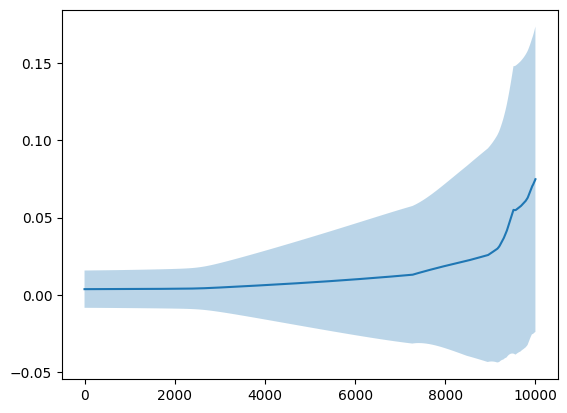

In [37]:
means = np.mean(diffs, axis=0)
stdss = np.std(diffs, axis=0)

plt.plot(means)
plt.fill_between(np.arange(len(means)), means - stdss, means + stdss, alpha=0.3)
plt.show()

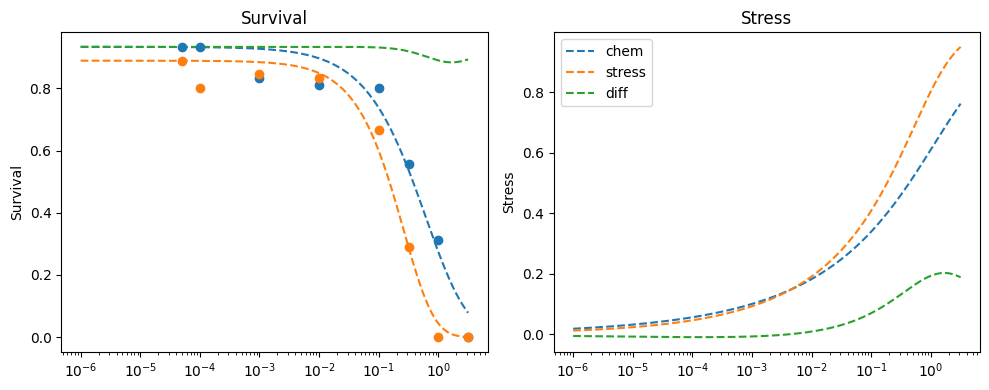

In [57]:
settings = StandardSettings(survival_max=data.meta.max_survival, param_d_norm=True)

main_fit = dose_response_fit(data.main_series, settings)

stress_fit = dose_response_fit(data.additional_stress[stressor], settings)

fig, axs = plt.subplots(1,2, figsize=(10, 4))

xscale = "log"

def plot_1(model, label):
    return plot_survival(
        model.concentration_curve,
        model.survival_curve,
        ax=axs[0],
        orig_series=model.inputs,
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Survival",
        title="Survival",
        label = label,
        color=None
    )
    
def plot_2(model, label):
    plot_stress(
        model.concentration_curve,
        model.stress_curve,
        ax=axs[1],
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Stress",
        title="Stress",
        label=label,
        color = None
    )
  

plot_1(main_fit, "chem")
plot_1(stress_fit, "stress")

plot_2(main_fit, "chem")
plot_2(stress_fit, "stress")

diff = stress_fit.stress_curve - main_fit.stress_curve 

plot_stress(
        main_fit.concentration_curve,
        diff,
        ax=axs[1],
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Stress",
        title="Stress",
        label="diff",
        color = None
    )


surv_diff = stress_to_survival(diff) * data.meta.max_survival

if settings.param_d_norm:
    surv_diff *= main_fit.optim_param["d"]

plot_survival(
        main_fit.concentration_curve,
        surv_diff,
        ax=axs[0],
        xscale=xscale,
        show_legend=False,
        xlab=None,
        ylab="Survival",
        title="Survival",
        label = "diff",
        color=None
    )

axs[-1].legend()
plt.tight_layout()
plt.show()